# Sales Forecast and analysis

## Quod Financial Technical Test

> Done by **Tristan PERROT**


## Import libraries


In [195]:
import plotly.graph_objects as go
import plotly.express as px
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import sys
import os
import plotly.io as pio
pio.renderers.default = "vscode"

## Import Data

In [196]:
DATA_DIR = '..' + os.sep + 'data'

transactions_1 = pd.read_csv(DATA_DIR + os.sep + 'transactions_1.csv', index_col=0, parse_dates=['date'])
transactions_2 = pd.read_csv(DATA_DIR + os.sep + 'transactions_2.csv', index_col=0, parse_dates=['date'])

In [197]:
transactions_1

,customer_id,product_id,date
0,8649525,Opel,2017-01-31 09:31:08.873000+00:00
1,8649525,Volkswagen,2017-02-03 16:59:16.610000+00:00
2,8649525,Volkswagen,2017-02-05 19:47:55.353000+00:00
3,8649525,Volkswagen,2017-02-05 19:48:14.633000+00:00
4,8649525,Volkswagen,2017-02-06 09:59:49.053000+00:00
...,...,...,...
499995,8822663,Fiat,2019-12-17 10:15:10.907000+00:00
499996,8822663,Renault,2017-09-26 08:00:46.090000+00:00
499997,8822663,Renault,2017-09-26 08:17:36.350000+00:00
499998,8822663,Renault,2017-09-26 09:05:09.700000+00:00


In [198]:
transactions_2

,customer_id,product_id,date
500000,8822663,Abarth,2018-06-28 09:19:11.130000+00:00
500001,8822663,Peugeot,2019-07-17 08:06:29.500000+00:00
500002,8822663,Nissan,2017-06-22 07:29:22.440000+00:00
500003,8822663,Nissan,2017-06-22 07:50:10.863000+00:00
500004,8822663,Nissan,2017-06-22 08:40:35.923000+00:00
...,...,...,...
975950,1111821,Renault,2019-05-17 10:06:43.037000+00:00
975951,4232782,Renault,2017-10-27 17:49:54.483000+00:00
975952,4746355,Seat,2019-01-09 16:31:08.133000+00:00
975953,4743766,Opel,2017-03-29 16:25:05.907000+00:00


In [199]:
transactions_1.info()

<class 'pandas.core.frame.DataFrame'>
Index: 500000 entries, 0 to 499999
Data columns (total 3 columns):
 #   Column       Non-Null Count   Dtype              
---  ------       --------------   -----              
 0   customer_id  500000 non-null  int64              
 1   product_id   500000 non-null  object             
 2   date         500000 non-null  datetime64[ns, UTC]
dtypes: datetime64[ns, UTC](1), int64(1), object(1)
memory usage: 15.3+ MB


In [200]:
all_transactions = pd.concat([transactions_1, transactions_2])

## Data Analysis

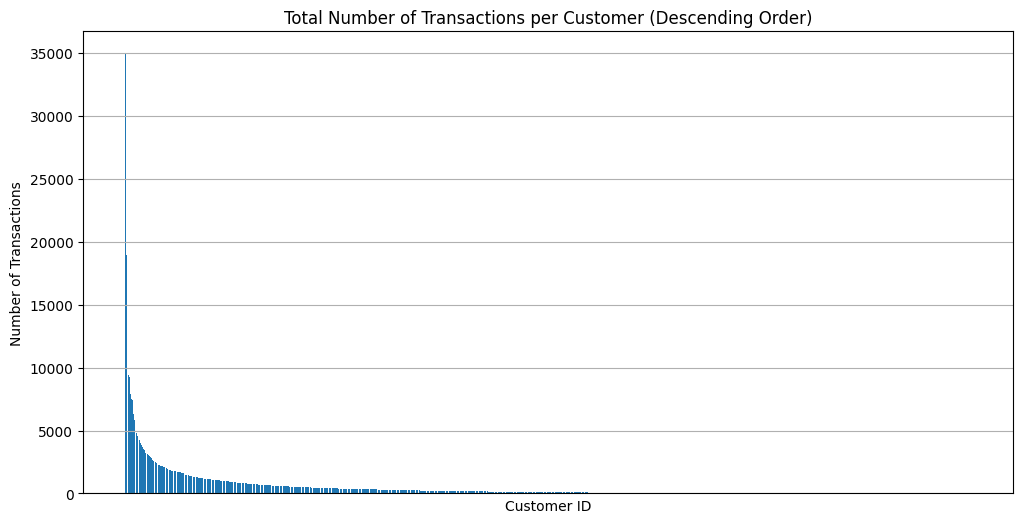

In [201]:
# Combine transactions and count the number per customer
transactions_per_customer = pd.concat([transactions_1, transactions_2]).groupby('customer_id').size()

# Sort in descending order
transactions_per_customer = transactions_per_customer.sort_values(ascending=False)

# Create the plot
plt.figure(figsize=(12, 6))
plt.bar(transactions_per_customer.index.astype(str), transactions_per_customer.values)

# Labels and title
plt.xlabel("Customer ID")  # Remove x-axis label text
plt.ylabel("Number of Transactions")
plt.title("Total Number of Transactions per Customer (Descending Order)")
plt.grid(axis='y')

# Remove x-axis ticks and labels for readability
plt.xticks([], []) 

# Show the plot
plt.show()

In [202]:
import dash
from dash import dcc, html
from dash.dependencies import Input, Output
import pandas as pd
import plotly.express as px

# Initialize Dash app
app = dash.Dash(__name__)

# Layout
app.layout = html.Div([
    dcc.Dropdown(
        id='product-dropdown',
        options=[{'label': p, 'value': p} for p in all_transactions['product_id'].unique()],
        value=all_transactions['product_id'].unique()[0],
        clearable=False
    ),
    dcc.Graph(id='product-transaction-plot')
])

# Callback to update the plot
@app.callback(
    Output('product-transaction-plot', 'figure'),
    Input('product-dropdown', 'value')
)
def update_graph(product_id):
    # Filter transactions for the selected product
    transactions_2018 = all_transactions[
        (all_transactions['date'].dt.year == 2018) & (all_transactions['product_id'] == product_id)
    ]

    # Group by month
    transactions_2018_per_month = transactions_2018.groupby(transactions_2018['date'].dt.month).size().reset_index()
    transactions_2018_per_month.columns = ['Month', 'Number of Transactions']

    # Map month numbers to names
    month_names = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
    transactions_2018_per_month['Month'] = transactions_2018_per_month['Month'].apply(lambda x: month_names[x-1])

    # Create the figure
    fig = px.bar(
        transactions_2018_per_month,
        x="Month",
        y="Number of Transactions",
        title=f"Transaction Frequency per Month for {product_id} in 2018",
        labels={"Month": "Month", "Number of Transactions": "Transaction Count"},
        text="Number of Transactions"
    )
    
    return fig

# Run the app
if __name__ == '__main__':
    app.run_server(debug=True)

## Prediction model

### Preprocessing

In [203]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error

all_transactions_2019 = all_transactions[
    (all_transactions['date'] >= "2019-01-01") & (all_transactions['date'] <= "2019-12-31")
]
all_transactions_2019['date'] = all_transactions['date'].dt.tz_localize(None)
transactions_2019 = all_transactions[all_transactions['date'].dt.year == 2019].copy()
transactions_2019['month'] = transactions_2019['date'].dt.to_period('M')
monthly_transactions = transactions_2019.groupby(['customer_id', 'month']).size().reset_index(name='num_transactions')

# Convert month back to datetime
monthly_transactions['month'] = monthly_transactions['month'].astype(str)
monthly_transactions['month'] = pd.to_datetime(monthly_transactions['month'])

# Pivot to create time-series data per customer
customer_transactions = monthly_transactions.pivot(index='customer_id', columns='month', values='num_transactions').fillna(0)

/var/folders/76/ktnqnwjn3kz2zdhpgy_03fww0000gn/T/ipykernel_82707/3454589868.py:11: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/var/folders/76/ktnqnwjn3kz2zdhpgy_03fww0000gn/T/ipykernel_82707/3454589868.py:13: UserWarning:

Converting to PeriodArray/Index representation will drop timezone information.



### Feature Engineering

In [204]:
# Create lag features (past transactions)
for i in range(1, 4):  # Lag features for past 3 months
    customer_transactions[f'lag_{i}'] = customer_transactions.iloc[:, -i-1]

# Create rolling mean features
customer_transactions['rolling_mean_3'] = customer_transactions.iloc[:, :-3].mean(axis=1)

# Drop rows with NaN (due to shifting)
customer_transactions = customer_transactions.dropna()

### Prepare data for model

In [210]:
# Define target variable (sum of next 3 months)
customer_transactions['target'] = customer_transactions.iloc[:, -4:-1].sum(axis=1)

# Select features (lagged data)
features = [f'lag_{i}' for i in range(1, 4)] + ['rolling_mean_3']
X = customer_transactions[features]
y = customer_transactions['target']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train a model
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# XGB Regressor
from xgboost import XGBRegressor

# Train a model
xgb_model = XGBRegressor(n_estimators=100, random_state=42)
xgb_model.fit(X_train, y_train)

# SVM Regressor
from sklearn.svm import SVR
from sklearn.preprocessing import StandardScaler

# Scale the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Train a model
svm_model = SVR(
    kernel='rbf',
    C=100,
    gamma=0.1
)
svm_model.fit(X_train_scaled, y_train)


# Make predictions
y_pred = model.predict(X_test)
y_pred_xgb = xgb_model.predict(X_test)
y_pred_svm = svm_model.predict(X_test_scaled)

### Evaluation

MAE: 8.53
RMSE: 41.88
MAE (XGB): 8.53
RMSE (XGB): 41.87
MAE (SVM): 12.50
RMSE (SVM): 59.25


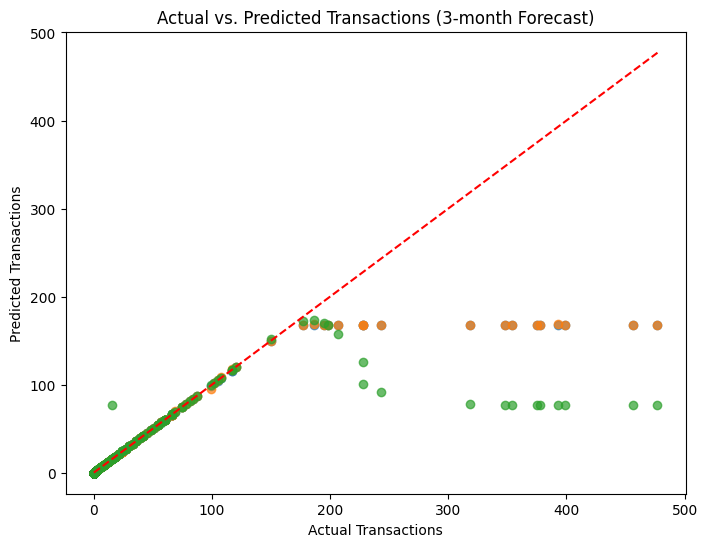

In [206]:
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
mae_xgb = mean_absolute_error(y_test, y_pred_xgb)
mse_xgb = mean_squared_error(y_test, y_pred_xgb)
mae_svm = mean_absolute_error(y_test, y_pred_svm)
mse_svm = mean_squared_error(y_test, y_pred_svm)
rmse = np.sqrt(mse)
rmse_xgb = np.sqrt(mse_xgb)
rmse_svm = np.sqrt(mse_svm)


print(f"MAE: {mae:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"MAE (XGB): {mae_xgb:.2f}")
print(f"RMSE (XGB): {rmse_xgb:.2f}")
print(f"MAE (SVM): {mae_svm:.2f}")
print(f"RMSE (SVM): {rmse_svm:.2f}")

# Scatter plot of actual vs. predicted transactions
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, alpha=0.7, label='Random Forest')
plt.scatter(y_test, y_pred_xgb, alpha=0.7, label='XGB')
plt.scatter(y_test, y_pred_svm, alpha=0.7, label='SVM')
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='--')
plt.xlabel("Actual Transactions")
plt.ylabel("Predicted Transactions")
plt.title("Actual vs. Predicted Transactions (3-month Forecast)")
plt.show()

## Data analysis

### Compute Sales per Product Over the Last 6 Months

In [207]:
import pandas as pd

# Convert date to datetime format if not already
all_transactions['date'] = pd.to_datetime(all_transactions['date'])

# Define function to get top 5 products for any given date
def top_products_last_six_months(reference_date):
    # Ensure reference_date has the same timezone as the date column
    reference_date = reference_date.tz_localize('UTC')
    
    # Filter transactions for the last 6 months from reference date
    start_date = reference_date - pd.DateOffset(months=6)
    recent_transactions = all_transactions[
        (all_transactions['date'] >= start_date) & (all_transactions['date'] <= reference_date)
    ]

    # Count sales per product
    product_sales = recent_transactions.groupby('product_id').size().reset_index(name='sales')

    # Get top 5 products
    top_5_products = product_sales.nlargest(5, 'sales')

    return top_5_products

# Example usage: Get top products for July 2019
top_products = top_products_last_six_months(pd.Timestamp("2019-07-31"))
print(top_products)

    product_id  sales
30     Renault  22047
38  Volkswagen   9695
27     Peugeot   9578
2         Audi   9170
3          BMW   8413


/var/folders/76/ktnqnwjn3kz2zdhpgy_03fww0000gn/T/ipykernel_82707/1634996462.py:4: UserWarning:

Converting to PeriodArray/Index representation will drop timezone information.



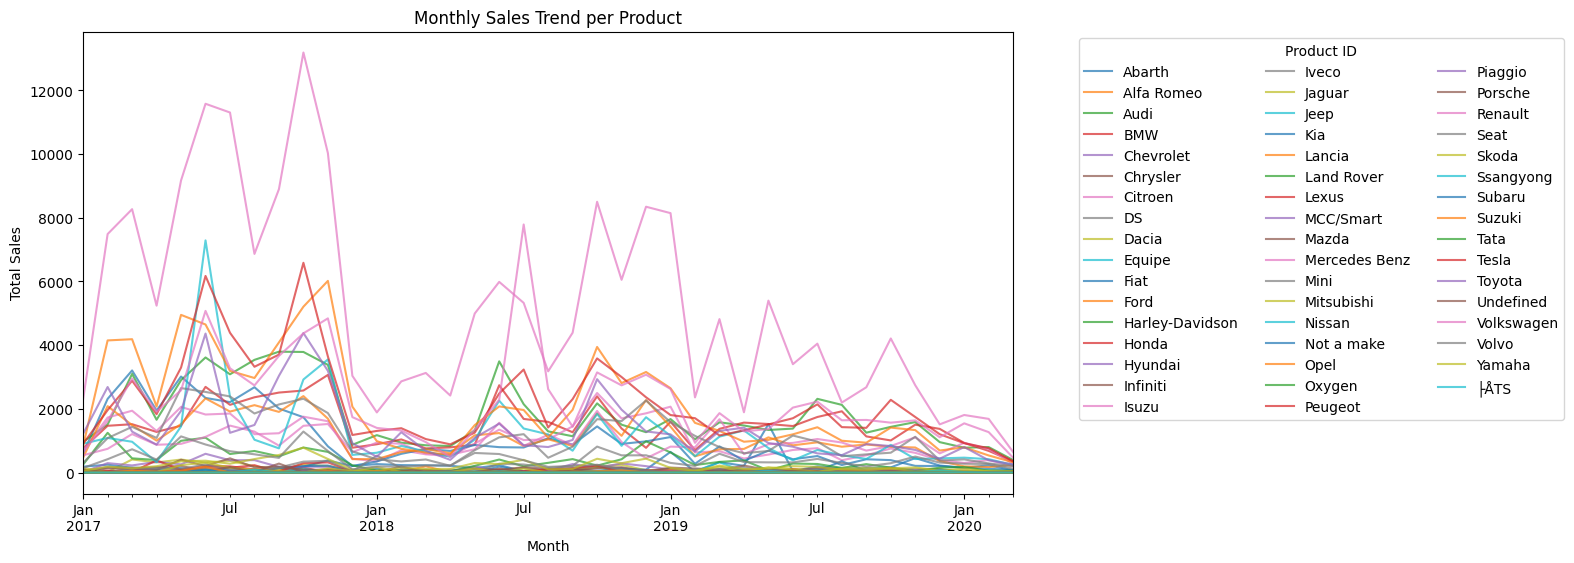

In [208]:
import matplotlib.pyplot as plt

# Aggregate sales per product per month
all_transactions['month'] = all_transactions['date'].dt.to_period('M')
monthly_sales = all_transactions.groupby(['month', 'product_id']).size().unstack(fill_value=0)

# Plot sales trends
plt.figure(figsize=(12, 6))
monthly_sales.plot(ax=plt.gca(), alpha=0.7)
plt.xlabel("Month")
plt.ylabel("Total Sales")
plt.title("Monthly Sales Trend per Product")
plt.legend(loc='upper right', bbox_to_anchor=(1.60, 1), title='Product ID', ncol=3)
plt.show()

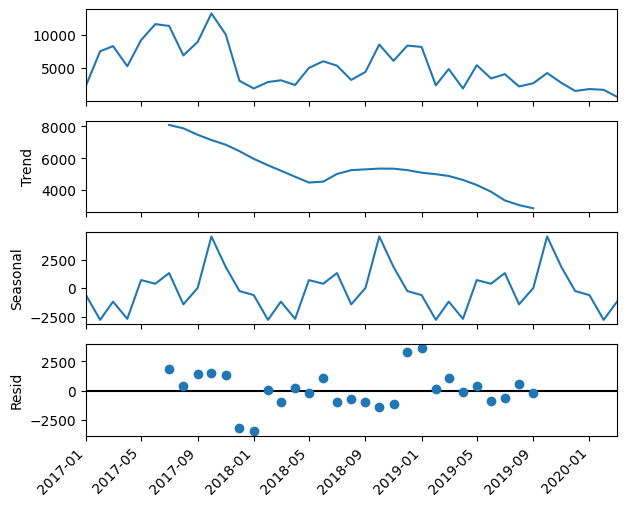

In [209]:
from statsmodels.tsa.seasonal import seasonal_decompose

# Select a product to analyze (e.g., top-selling product)
product_id = all_transactions['product_id'].value_counts().idxmax()

# Filter time series data for this product
product_sales = all_transactions[all_transactions['product_id'] == product_id].groupby('month').size()

# Convert Period to Timestamp
product_sales.index = product_sales.index.to_timestamp()

# Apply seasonal decomposition
decomposition = seasonal_decompose(product_sales, model='additive', period=12)

# Plot decomposition
decomposition.plot()
plt.xticks(rotation=45, ha='right')
plt.show()